In [19]:
import psycopg2
#import library pandas
import pandas as pd
#import library sqlio
import pandas.io.sql as sqlio

In [20]:
#create database connection variable 
conn = psycopg2.connect(user="postgres", password="root1234", host="localhost", database="DVDRental")

In [21]:
#define query
query = "select * from sales c;"

#execute query and save it to a variable
sqlio.read_sql_query(query,conn)

,brand,segment,quantity
0,ABC,Premium,100
1,ABC,Basic,200
2,XYZ,Premium,100
3,XYZ,Basic,300


Suppose you want to display data in the following format

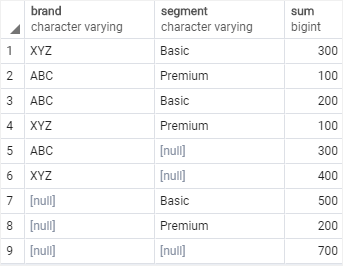

In [22]:
# Query1:
query = """SELECT brand, segment, SUM (quantity)
           FROM sales
           GROUP BY brand, segment;"""
sqlio.read_sql_query(query,conn)

,brand,segment,sum
0,XYZ,Basic,300
1,ABC,Premium,100
2,ABC,Basic,200
3,XYZ,Premium,100


In [23]:
# Query2:
query = """SELECT brand, SUM (quantity)
        FROM sales
        GROUP BY brand;"""
sqlio.read_sql_query(query,conn)

,brand,sum
0,ABC,300
1,XYZ,400


In [24]:
# Query3:
query = """SELECT segment, SUM (quantity)
           FROM sales
           GROUP BY segment;"""
sqlio.read_sql_query(query,conn)

,segment,sum
0,Basic,500
1,Premium,200


In [25]:
# Query4:
query = """SELECT SUM (quantity) FROM sales;"""
sqlio.read_sql_query(query,conn)

,sum
0,700


Use UNION ALL operator

In [26]:
## UNION ALL
query = """SELECT brand, segment, SUM (quantity) FROM sales
           GROUP BY brand,segment
UNION ALL
           SELECT brand,NULL,SUM (quantity) FROM sales
           GROUP BY brand
UNION ALL
           SELECT NULL, segment, SUM (quantity) FROM sales
           GROUP BY segment
UNION ALL
           SELECT NULL, NULL, SUM (quantity) FROM sales;"""
sqlio.read_sql_query(query,conn)

,brand,segment,sum
0,XYZ,Basic,300
1,ABC,Premium,100
2,ABC,Basic,200
3,XYZ,Premium,100
4,ABC,None,300
5,XYZ,None,400
6,None,Basic,500
7,None,Premium,200
8,None,None,700


The above query has two main problems.

1. it is quite lengthy.
2. it has a performance issue because PostgreSQL has to scan the sales table separately for each query.

In [27]:
query = """SELECT brand, segment, SUM (quantity)
           FROM sales
           GROUP BY
           GROUPING SETS (
        (brand, segment),
        (brand),
        (segment),
        ());"""
sqlio.read_sql_query(query,conn)

,brand,segment,sum
0,None,None,700
1,XYZ,Basic,300
2,ABC,Premium,100
3,ABC,Basic,200
4,XYZ,Premium,100
5,ABC,None,300
6,XYZ,None,400
7,None,Basic,500
8,None,Premium,200


** This query is much shorter and more readable. 
** PostgreSQL will optimize the number of times it scans the sales table and will not scan multiple times.

### ROLL UP operation
* extension of the GROUP BY clause
* generally, used for data analytics operations

### **Syntex:** <br>

**SELECT <br>
c1, c2, c3, aggregate_function(c4) <br>
FROM <br>
table <br>
GROUP BY ROLLUP (c1, c2, c3); **

ROLLUP (c2, c1, c3);
R

* For Reporting of sub-total and grand-total, we use ROLLUP.

ROLLUP(c1,c2,c3) generates three following grouping sets:
* (c1, c2, c3)
* (c1,c2)
* (c1)
* ()

We can also perform partial ROLLUP to reduce the count of sub-totals created. <br>

**SELECT <br>
c1, c2, c3, aggregate(c4) <br>
FROM <br>
table_name <br>
GROUP BY <br>
c1, ROLLUP (c2, c3);**

In [10]:
# new table "furniture"
query = """SELECT * from furniture"""

sqlio.read_sql_query(query,conn)

,furniture_id,furniture_name,furniture_type,furniture_price
0,1,Chair,Wood,2500
1,2,Chair,Plastic,2000
2,3,Table,Wood,5000
3,4,Table,Plastic,4000
4,5,Sofa,Wood,10000
5,6,Sofa,Plastic,8000
6,7,Bed,Wood,15000
7,8,Bed,Plastic,13000


In [28]:
# Total furniture price group by furniture_name

query = """SELECT furniture_name, SUM(furniture_price)
           FROM furniture GROUP BY furniture_name;"""

sqlio.read_sql_query(query,conn)


,furniture_name,sum
0,Table,9000
1,Bed,28000
2,Chair,4500
3,Sofa,18000


In order to fetch the total furniture price of all furniture, we can use ROLLUP to the GROUP BY clause


In [ ]:
group by furniture name
() - sum

In [12]:
query = """SELECT furniture_name, SUM(furniture_price)
            FROM furniture
            GROUP BY ROLLUP (furniture_name);"""

sqlio.read_sql_query(query,conn)

,furniture_name,sum
0,None,59500
1,Table,9000
2,Bed,28000
3,Chair,4500
4,Sofa,18000


In the above example, the ROLLUP option allows the statement to add an extra row that shows the total furniture price of all furniture.

In [13]:
query = """SELECT COALESCE(furniture_name, 'Total furniture price') AS furniture_name,
          SUM(furniture_price)FROM furniture
          GROUP BY ROLLUP (furniture_name);"""

sqlio.read_sql_query(query,conn)

,furniture_name,sum
0,Total furniture price,59500
1,Table,9000
2,Bed,28000
3,Chair,4500
4,Sofa,18000


### ROLLUP with multiple columns

In [29]:
query = """SELECT furniture_name, furniture_type, SUM(furniture_price)
           FROM furniture
           GROUP BY furniture_name, furniture_type;"""

sqlio.read_sql_query(query,conn)

,furniture_name,furniture_type,sum
0,Table,Wood,5000
1,Bed,Plastic,13000
2,Table,Plastic,4000
3,Chair,Plastic,2000
4,Bed,Wood,15000
5,Chair,Wood,2500
6,Sofa,Wood,10000
7,Sofa,Plastic,8000


In [15]:
query = """SELECT furniture_name, furniture_type, SUM(furniture_price)
           FROM furniture
           GROUP BY ROLLUP (furniture_name , furniture_type);"""

sqlio.read_sql_query(query,conn)

,furniture_name,furniture_type,sum
0,None,None,59500
1,Table,Wood,5000
2,Bed,Plastic,13000
3,Table,Plastic,4000
4,Chair,Plastic,2000
5,Bed,Wood,15000
6,Chair,Wood,2500
7,Sofa,Wood,10000
8,Sofa,Plastic,8000
9,Table,None,9000


### Example #3 – ROLLUP with a partial rollup

We can also do a partial rollup which reduces the count of sub-totals generated.

In [16]:
query = """SELECT furniture_name, furniture_type, SUM(furniture_price)
          FROM furniture GROUP BY furniture_name, 
          ROLLUP (furniture_type);"""

sqlio.read_sql_query(query,conn)

,furniture_name,furniture_type,sum
0,Table,Wood,5000
1,Bed,Plastic,13000
2,Table,Plastic,4000
3,Chair,Plastic,2000
4,Bed,Wood,15000
5,Chair,Wood,2500
6,Sofa,Wood,10000
7,Sofa,Plastic,8000
8,Table,None,9000
9,Bed,None,28000


Above query generates an aggregate summary for the furniture_type column, not the furniture_name column.

### CUBE 
* subclause of the GROUP BY clause. 
* allows to generate multiple grouping sets.

The CUBE subclause is a short way to define multiple grouping sets 

CUBE(c1,c2,c3) <br>

**equivalent to**

GROUPING SETS ( <br>
    (c1,c2,c3), <br>
    (c1,c2),<br>
    (c1,c3),<br>
    (c2,c3),<br>
    (c1),<br>
    (c2),<br>
    (c3), <br>
    ()<br>
 ) 


In general, if the number of columns specified in the CUBE is n, then we will have power(2,n) combinations

In [17]:
query = """SELECT brand, segment, SUM (quantity)
           FROM sales
            GROUP BY CUBE (brand, segment)
            ORDER BY brand, segment;"""

sqlio.read_sql_query(query,conn)



,brand,segment,sum
0,ABC,Basic,200
1,ABC,Premium,100
2,ABC,None,300
3,XYZ,Basic,300
4,XYZ,Premium,100
5,XYZ,None,400
6,None,Basic,500
7,None,Premium,200
8,None,None,700


In [18]:
# following query performs partial cube
query = """SELECT brand, segment, SUM (quantity)
           FROM sales
            GROUP BY brand, CUBE (segment)
            ORDER BY brand, segment;"""

sqlio.read_sql_query(query,conn)

,brand,segment,sum
0,ABC,Basic,200
1,ABC,Premium,100
2,ABC,None,300
3,XYZ,Basic,300
4,XYZ,Premium,100
5,XYZ,None,400


When to use Grouping Sets, Cube and Rollup

* These are performance tools


